---
# Import and definitions

In [190]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display
import os
import glob
import math

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

from librosa.feature import mfcc
from scipy.io import wavfile
from hmmlearn import hmm
import warnings
import scipy.stats as sp
from time import time

warnings.filterwarnings("ignore")

Parameter definitions

In [126]:
Fs = 16000  # sampling rate
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1


이전 lab 들에서 정의한 함수들 import

In [127]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

# save audio in wav format
import gjwavfile as x

Load dataset

In [128]:
def check_audio_file(file, defFs, checkMono):
    signal, Fs = librosa.load(file, sr=None, mono=False)
    if defFs != Fs:
        print('sampling rate mismatch, %d != %d for file %s'%(defFs, Fs, file))
        return False
    elif checkMono == True:
        if signal.ndim != 1:
            print('not mono file %s, shape='%(file), signal.shape)
            return False
        return True
    elif len(signal) <= 0:
        print('wrong audio file %s, shape='%(file), signal.shape)
    else:
        return True

def convert_audio_file(file, forceFs, forceMono):
    signal, Fs = librosa.load(file, sr=None, mono=False)
    changed = False
    if forceFs != Fs:
        print('sampling rate mismatch, %d != %d for file %s'%(forceFs, Fs, file))
        signal, Fs = librosa.load(file, sr=forceFs, mono=False)
        changed = True
    elif forceMono == True:
        if signal.ndim != 1:
            print('not mono file %s, shape='%(file), signal.shape)
            signal, Fs = librosa.load(file, sr=forceFs, mono=True)
            changed = True
    elif len(signal) <= 0:
        print('wrong audio file %s, shape='%(file), signal.shape)
        return False
    if changed == True:
        x.writewav(file, Fs, signal, maxval=1.0)
        print('updating', file)
    return changed

오디오 파일 확인

In [129]:
datasetroot = '../audio/proj1-dataset'

trainroot = os.path.join(datasetroot, 'segmented-train')

# labels_all = {
#     '11jeonghy',
#     'Dandyst',
#     'InkooJeon',
#     'YouYeNa',
#     'chlee',
#     'deokkyukwon',
#     'do',
#     'kyeong',
#     'ohjihyeon',
#     'son',
# }

labels_train = {
    '11jeonghy',
    'Dandyst',
    'InkooJeon',
    'YouYeNa',
    # 'deokkyukwon',
    # 'ohjihyeon',
    'son',
}

# check
for subname in labels_train:
    num_files = 0
    num_false_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav' % (w, trial, w)
            file = os.path.join(trainroot, subname, basename)
            num_files += 1
            if check_audio_file(file, Fs, True) == False:
                num_false_files += 1
    print('%s: false %d / %d\n' % (subname, num_false_files, num_files))


InkooJeon: false 0 / 100

YouYeNa: false 0 / 100

11jeonghy: false 0 / 100

Dandyst: false 0 / 100

son: false 0 / 100



In [130]:
valroot = os.path.join(datasetroot, 'segmented-val')

valpathall = glob.glob(valroot + '*/*')
# valclean = os.path.join(valroot, 'org')
labels_val = {
    'chlee',
    'do',
    # 'kyeong',
}

# check
for valpath in valpathall:
    for subname in labels_val:
        num_files = 0
        num_false_files = 0
        for w in range(10):
            for trial in range(10):
                basename = '%d/kdigits%d-%d.wav' % (w, trial, w)
                file = os.path.join(valpath, subname, basename)
                num_files += 1
                if check_audio_file(file, Fs, True) == False:
                    num_false_files += 1
        print('%s\%s: false %d / %d\n' % (os.path.split(valpath)[-1], subname, num_false_files, num_files))


wbnSNR-10\do: false 0 / 100

wbnSNR-10\chlee: false 0 / 100

org\do: false 0 / 100

org\chlee: false 0 / 100

wbnSNR10\do: false 0 / 100

wbnSNR10\chlee: false 0 / 100

nbnSNR0\do: false 0 / 100

nbnSNR0\chlee: false 0 / 100

wbnSNR0\do: false 0 / 100

wbnSNR0\chlee: false 0 / 100

nbnSNR-10\do: false 0 / 100

nbnSNR-10\chlee: false 0 / 100

nbnSNR10\do: false 0 / 100

nbnSNR10\chlee: false 0 / 100



In [131]:
testroot = os.path.join(datasetroot, 'unsegmented-test')

test_clean = os.path.join(testroot, 'org')

test_nbnSNR10 = os.path.join(testroot, 'nbnSNR10')
test_nbnSNR0 = os.path.join(testroot, 'nbnSNR0')
test_nbnSNRm10 = os.path.join(testroot, 'nbnSNR-10')

test_wbnSNR10 = os.path.join(testroot, 'wbnSNR10')
test_wbnSNR0 = os.path.join(testroot, 'wbnSNR0')
test_wbnSNRm10 = os.path.join(testroot, 'wbnSNR-10')

test_dataset = [test_clean, test_nbnSNR10, test_nbnSNR0, test_nbnSNRm10, test_wbnSNR10, test_wbnSNR0, test_wbnSNRm10]

labels_test = {
    'gjang',
}

# check
for test in test_dataset:
    for subname in labels_test:
        num_files = 0
        num_false_files = 0

        for trial in range(10):
            basename = 'kdigits%d.wav' % (trial)
            file = os.path.join(test, subname, basename)
            num_files += 1
            if check_audio_file(file, Fs, True) == False:
                num_false_files += 1
        print('%s: false %d / %d\n' % (os.path.split(test)[-1], num_false_files, num_files))


org: false 0 / 10

nbnSNR10: false 0 / 10

nbnSNR0: false 0 / 10

nbnSNR-10: false 0 / 10

wbnSNR10: false 0 / 10

wbnSNR0: false 0 / 10

wbnSNR-10: false 0 / 10



---
# 1. HMM training and validation
ref: [proj1_nidr](proj1_nidr.ipynb)

Definitions

In [132]:
############################################################################################## 
# extract MFCC features from file
def extmfcc(file):
    d, samplerate = librosa.load(file, sr=None, mono=False)

    # samplerate, d = wavfile.read(file)
    #features.append(mfcc(d, nwin=int(samplerate * 0.03), fs=samplerate, nceps= 6)[0])
    
    x = np.float32(d)
    hop=samplerate//100
    # mc = mfcc(y=x, sr=samplerate, n_mfcc=num_mfcc, hop_length=hop, win_length=hop*2)
    mc = librosa.feature.mfcc(y=x, sr=samplerate, n_mfcc=num_mfcc, hop_length=hop, win_length=hop*2)
    return np.transpose(mc, (1,0))

# extract MFCC from wav data
def extmfcc_wav(wav):
    samplerate = Fs
    d = wav
    # samplerate, d = wavfile.read(file)
    #features.append(mfcc(d, nwin=int(samplerate * 0.03), fs=samplerate, nceps= 6)[0])
    x = np.float32(d)
    hop=samplerate//100

    # mc = mfcc(y=x, sr=samplerate, n_mfcc=num_mfcc, hop_length=hop, win_length=hop*2)
    mc = librosa.feature.mfcc(y=x, sr=samplerate, n_mfcc=6, hop_length=hop, win_length=hop*2)

    return np.transpose(mc, (1,0))

def initByBakis(inumstates, ibakisLevel):
    startprobPrior = np.zeros(inumstates)
    startprobPrior[0: ibakisLevel - 1] = 1/float((ibakisLevel - 1))
    transmatPrior = getTransmatPrior(inumstates, ibakisLevel)
    return startprobPrior, transmatPrior

def getTransmatPrior(inumstates, ibakisLevel):
    transmatPrior = (1 / float(ibakisLevel)) * np.eye(inumstates)

    for i in range(inumstates - (ibakisLevel - 1)):
        for j in range(ibakisLevel - 1):
            transmatPrior[i, i + j + 1] = 1. / ibakisLevel

    for i in range(inumstates - ibakisLevel + 1, inumstates):
        for j in range(inumstates - i - j):
            transmatPrior[i, i + j] = 1. / (inumstates - i)

    return transmatPrior


############################################################################################## 
# hyperparameters - CHANGE THEM TO IMPROVE PERFORMANCE
# 1. number of MFCC (feature dimension)
num_mfcc = 6
#num_mfcc = 10
#num_mfcc = 13
# 2. Parameters needed to train GMMHMM
m_num_of_HMMStates = 3  # number of states
m_num_of_mixtures = 2  # number of mixtures for each hidden state
m_covarianceType = 'diag'  # covariance type
m_n_iter = 10  # number of iterations
m_bakisLevel = 2
m_startprobPrior, m_transmatPrior = initByBakis(m_num_of_HMMStates,m_bakisLevel)
print("StartProbPrior="); print(m_startprobPrior)
print("TransMatPrior="); print(m_transmatPrior)


############################################################################################## 
# acoustic model definition
class SpeechModel:
    def __init__(self,Class,label):
        self.traindata = np.zeros((0,num_mfcc))
        self.Class = Class
        self.label = label
        self.model  = hmm.GMMHMM(n_components = m_num_of_HMMStates, n_mix = m_num_of_mixtures, \
                transmat_prior = m_transmatPrior, startprob_prior = m_startprobPrior, \
                covariance_type = m_covarianceType, n_iter = m_n_iter)

##################################################################################
# folder structure:
#  ${rootpath} / ${speaker_name} / m:0-9 / ${tag}[t:0-${numtrials}]-[m:0-9]
#    m:0-9 model number
#    t:0-{numtrials} trial number
#  example: train_digits('segmented-train', {'gjang', 'do', 'son'}, 'kdigis', 10) 
#           will train with
#    segmented-train/gjang/0/kdigits0-0.wav
#    segmented-train/gjang/0/kdigits1-0.wav
#    ...
#    segmented-train/son/9/kdigits8-9.wav
#    segmented-train/son/9/kdigits9-9.wav
##################################################################################


StartProbPrior=
[1. 0. 0.]
TransMatPrior=
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


Train HMM

In [133]:
def train_digits(rootpath, speakers, tag, num_trials=10):    
    ############################################################################################## 
    # 1. find files
    #    for user "gjang", digit 2, recording trial 0 (1st)
    #    "segmented/gjang/2/kdigits0-2.wav"
    # 2. extract MFCC features for training and testing
    #    for each digit, indexes 4 and 9 for test, and the rest for training

    #fpaths = []
    #labels = []
    spoken = []
    m_trainingsetfeatures = []
    m_trainingsetlabels = []

    count = 0
    for username in speakers:
        apath2 = os.path.join(rootpath, username)    # example: segmented/gjang
        for ii in range(10):   #dnum in os.listdir(apath2):
            dnum = str(ii)
            apath3 = os.path.join(apath2, dnum)     # example: segmented/gjang/2
            if dnum not in spoken:
                spoken.append(dnum)
            for trial in range(num_trials):
                file = os.path.join(apath3,"{}{}-{}.wav".format(tag,trial,dnum))      # segmented/gjang/2/kdigits0-2.wav
                mc = extmfcc(file)
                # print(mc.shape)

                # display file names for the first 20 files only
                count += 1
                # if count <= 20:
                #     print(file, dnum, end=' '); print(mc.shape, end=' ')
                # elif count == 21:
                #     print('...'); print('')

                m_trainingsetfeatures.append(mc)
                m_trainingsetlabels.append(dnum)

    # print('Words spoken:', spoken)
    #print("number of labels and features = %d, %d" % ( len(labels), len(features) ))
    #print("feature shape = ", end='')
    #print(features[0].shape)

    ############################################################################################## 
    ntrain = len(m_trainingsetlabels)

    print("[training] number of labels and features = %d, %d" % 
            ( len(m_trainingsetlabels), len(m_trainingsetfeatures)) )
    print ('Loading data completed')

    ############################################################################################## 
    # model initialization
    gmmhmmindexdict = {}
    index = 0
    for word in spoken:
        gmmhmmindexdict[word] = index
        index = index +1

    ############################################################################################## 
    # training GMMHMM Models 
    start = time()

    speechmodels = [None] * len(spoken)
    for key in gmmhmmindexdict:
        speechmodels[gmmhmmindexdict[key]] = SpeechModel(gmmhmmindexdict[key],key)

    for i in range(0,len(m_trainingsetfeatures)):
         for j in range(0,len(speechmodels)):
             if int(speechmodels[j].Class) == int(gmmhmmindexdict[m_trainingsetlabels[i]]):
                speechmodels[j].traindata = np.concatenate((speechmodels[j].traindata , m_trainingsetfeatures[i]))

    for speechmodel in speechmodels:
        speechmodel.model.fit(speechmodel.traindata)

    print ('Training completed -- {0} GMM-HMM models are built for {0} different types of words'.format(len(spoken)))
    print('time elapsed: %.2f seconds' % ( time() - start ))
    print (" "); print(" ")
    
    return speechmodels, gmmhmmindexdict

Validation from files

In [134]:
##################################################################################
# folder structure:
#  ${rootpath} / ${speaker_name} / m:0-9 / ${tag}[t:0-${numtrials}]-[m:0-9]
#    m:0-9 model number
#    t:0-{numtrials} trial number
#  example: train_digits('segmented-train', {'gjang', 'do', 'son'}, 'kdigis', 10) 
#           will train with
#    segmented-train/gjang/0/kdigits0-0.wav
#    segmented-train/gjang/0/kdigits1-0.wav
#    ...
#    segmented-train/son/9/kdigits8-9.wav
#    segmented-train/son/9/kdigits9-9.wav
##################################################################################
def validation_digits_from_files(speechmodels, gmmhmmindexdict, rootpath, speakers, tag, num_trials=10):    

    ############################################################################################## 
    # 1. find files
    #    for user "gjang", digit 2, recording trial 0 (1st)
    #    "segmented/gjang/2/kdigits0-2.wav"
    # 2. extract MFCC features for training and testing
    #    for each digit, indexes 4 and 9 for test, and the rest for training

    #fpaths = []
    #labels = []
    spoken = []
    m_features = []
    m_labels = []

    count = 0
    for username in speakers:
        apath2 = os.path.join(rootpath, username)    # example: segmented/gjang
        for ii in range(10):   #dnum in os.listdir(apath2):
            dnum = str(ii)
            apath3 = os.path.join(apath2, dnum)     # example: segmented/gjang/2
            if dnum not in spoken:
                spoken.append(dnum)
            for trial in range(num_trials):
                file = os.path.join(apath3,"{}{}-{}.wav".format(tag,trial,dnum))      # segmented/gjang/2/kdigits0-2.wav
                mc = extmfcc(file)

                # display file names for the first 20 files only
                count += 1
                # if count <= 20:
                #     print(file, dnum, end=' '); print(mc.shape, end=' ')
                # elif count == 21:
                #     print('...'); print('')

                m_features.append(mc)
                m_labels.append(dnum)

    # print(len(m_features),len(m_features[0]))
    # print(len(m_labels),len(m_labels[0]))

    # print('Words spoken:', spoken)
    #print("number of labels and features = %d, %d" % ( len(labels), len(features) ))
    #print("feature shape = ", end='')
    #print(features[0].shape)

    ############################################################################################## 
    # print("[validation] number of labels and features = %d, %d" % ( len(m_labels), len(m_features)) )
    # print ('Loading data completed')

    ############################################################################################## 
    # testing
    # print("Prediction started")
    m_PredictionlabelList = []

    for i in range(0,len(m_features)):
        scores = []
        for speechmodel in speechmodels:
             scores.append(speechmodel.model.score(m_features[i]))
        id  = scores.index(max(scores))
        m_PredictionlabelList.append(speechmodels[id].Class)
        #print(str(np.round(scores, 3)) + " " + str(max(np.round(scores, 3))) +" "+":"+ speechmodels[id].label)

    accuracy = 0.0
    count = 0
    # print("")
    # print("Prediction for Testing DataSet:")

    for i in range(0,len(m_labels)):
        #print( "Label"+str(i+1)+":"+m_labels[i])
        if gmmhmmindexdict[m_labels[i]] == m_PredictionlabelList[i]:
           count = count+1

    accuracy = 100.0*count/float(len(m_labels))

    # print("")
    print("accuracy = "+str(accuracy))
    # print("")

    ############################################################################################## 
    # end of testing
    ############################################################################################## 

Validation from features

In [135]:
def validation_digits_from_features(speechmodels, m_labels, m_features):

    ############################################################################################## 
    # testing
    # print("Prediction started")
    m_PredictionlabelList = []

    for i in range(0,len(m_features)):
        scores = []
        for speechmodel in speechmodels:
             scores.append(speechmodel.model.score(m_features[i]))
        id  = scores.index(max(scores))
        m_PredictionlabelList.append(speechmodels[id].Class)
        #print(str(np.round(scores, 3)) + " " + str(max(np.round(scores, 3))) +" "+":"+ speechmodels[id].label)

    accuracy = 0.0
    count = 0
    # print("")
    # print("Prediction for Testing DataSet:")

    # print('len_labels', len(m_labels), len(m_PredictionlabelList))
    for i in range(0,len(m_labels)):
        #print( "Label"+str(i+1)+":"+m_labels[i])
        # print('labels i', m_labels[i], m_PredictionlabelList[i])
        if m_labels[i] == m_PredictionlabelList[i]:
           count = count+1

    accuracy = 100.0*count/float(len(m_labels))

    # print("")
    print("accuracy = "+str(accuracy))
    # print("")

    ############################################################################################## 
    # end of testing
    ############################################################################################## 

### HMM training and testing

In [136]:
# Train models
speechmodels, gmmhmmindexdict = train_digits(trainroot, labels_train, 'kdigits', num_trials=10)

[training] number of labels and features = 500, 500
Loading data completed
Training completed -- 10 GMM-HMM models are built for 10 different types of words
time elapsed: 8.27 seconds
 
 


Validation

In [137]:
print('train : ', end='')
validation_digits_from_files(speechmodels, gmmhmmindexdict, trainroot, labels_train, 'kdigits', num_trials=10)

for valpath in valpathall:
    print(os.path.split(valpath)[-1],':', end='')
    validation_digits_from_files(speechmodels, gmmhmmindexdict, valpath, labels_val, 'kdigits', num_trials=10)

train : accuracy = 47.0
wbnSNR-10 :accuracy = 9.5
org :accuracy = 44.0
wbnSNR10 :accuracy = 29.0
nbnSNR0 :accuracy = 24.0
wbnSNR0 :accuracy = 16.5
nbnSNR-10 :accuracy = 10.0
nbnSNR10 :accuracy = 35.5


---
# 2. Audio segmentation using EPD

Load unsegment test files

In [92]:
# Test files to wav
def load_unsegmented_wavs(path):
    wavs = []

    for trial in range(10):
        basename = 'kdigits%d.wav' % (trial)
        filepath = os.path.join(path, basename)
        wav, _ = librosa.load(filepath)
        wavs.append(wav)
    
    return wavs

### EPD function
EPD를 활용하여 분할 지점을 찾고, 오디오 segment의 start/end 쌍을 리스트로 반환

In [93]:
# 분할 지점을 찾는 함수
# start/end 쌍을 반환

# energy_thd: energy threshold
# t_gap_thd: 분할 지점 사이의 최소 시간 간격
# extend: segment 앞뒤로 몇 샘플씩 더 확장할지 지정

def find_endpoints(x, frame_t=0.002, energy_thd=0.1, t_gap_thd=100):
    endpoints = []

    frame_size = int(Fs * frame_t)
    num_frames = int(np.ceil(float(np.abs(len(x) - frame_size)) / frame_size))
    
    for i in range(num_frames):
        start = i * frame_size
        end = start + frame_size

        frame_energy = np.sqrt(np.sum(x[start:end].astype(np.float32)**2)/frame_size)

        if frame_energy > energy_thd:
            endpoints.append(i)

    diffs = np.diff(endpoints)

    split_indices = np.where(diffs > t_gap_thd)[0] + 1

    split_all = np.split(endpoints, split_indices)
    
    result = []
    for split in split_all:
        split = split*frame_size
        
        result.append([split[0], split[-1]])

    return np.array(result)


In [94]:
# 구한 endpoint를 기준으로 wav를 분할
def split_with_endpoints(wav, epds, extends=1600):
    split_wav = []
    for epd in epds:
        if epd[0]-extends < 0:
            start = 0
        else:
            start = epd[0]-extends

        if epd[1]+extends >= len(wav):
            end = len(wav)
        else:
            end = epd[1]+extends
        split_wav.append(wav[start:end])

    return split_wav

Plot functions

In [205]:
def plot_wav_epd(wav, epds):
    plt.figure(figsize=(10,5))
    plt.plot(wav)
    for epd in epds:
        plt.axvline(x=epd[0], color='red', linestyle='--')
        plt.axvline(x=epd[1], color='red', linestyle='--')
    plt.show()

In [206]:
def plot_splits(splits):
    plt.figure(figsize=(10,8))
    row = math.ceil(len(splits)/2)
    for i, split in enumerate(splits):
        plt.subplot(row,2,i+1)
        drawspectrogram3(split, Fs, NFFT, Ns)

EPD Test: Clean

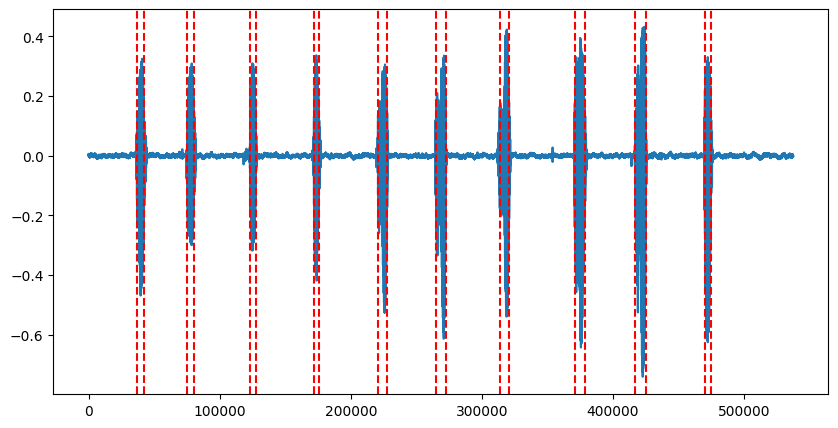

In [242]:
test_clean_wav = load_unsegmented_wavs(os.path.join(test_clean,'gjang'))

x = test_clean_wav[0]

epds_clean = find_endpoints(x, energy_thd=0.1, t_gap_thd=100)

plot_wav_epd(x, epds_clean)

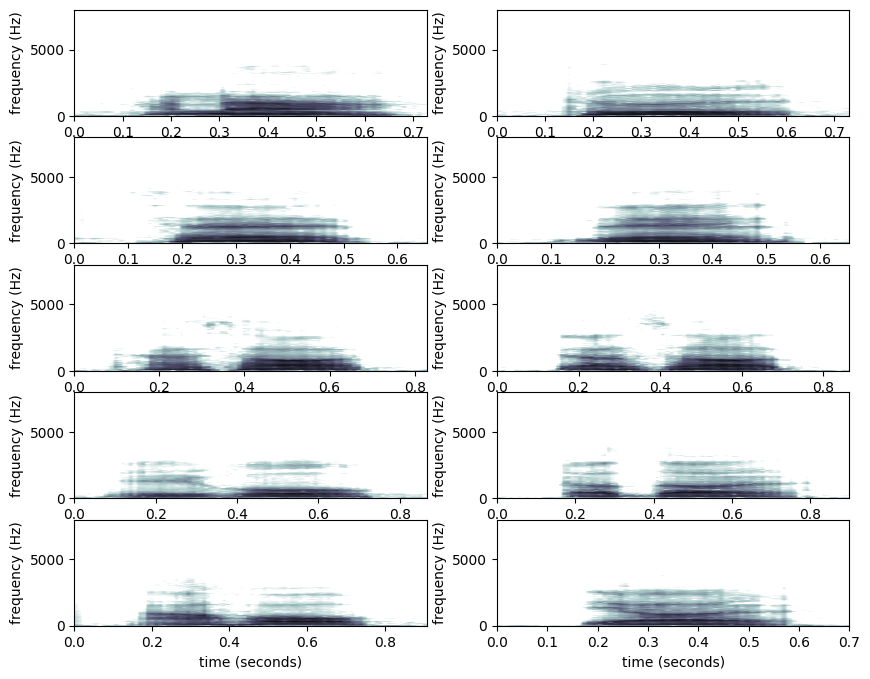

In [243]:
split_wav_clean = split_with_endpoints(x, epds_clean, extends=3200)

plot_splits(split_wav_clean)


EPD Test: Noisy

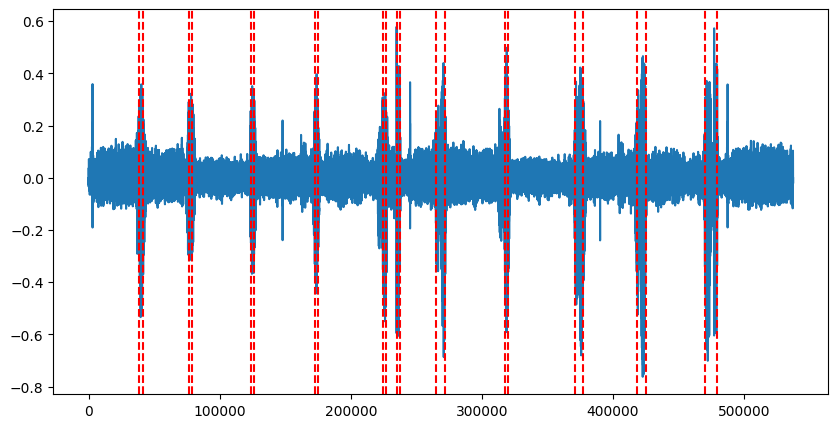

In [246]:
test_snr0_wav = load_unsegmented_wavs(os.path.join(test_nbnSNR0,'gjang'))

x = test_snr0_wav[0]

epds_noisy = find_endpoints(x, energy_thd=0.2, t_gap_thd=100)

plot_wav_epd(x, epds_noisy)


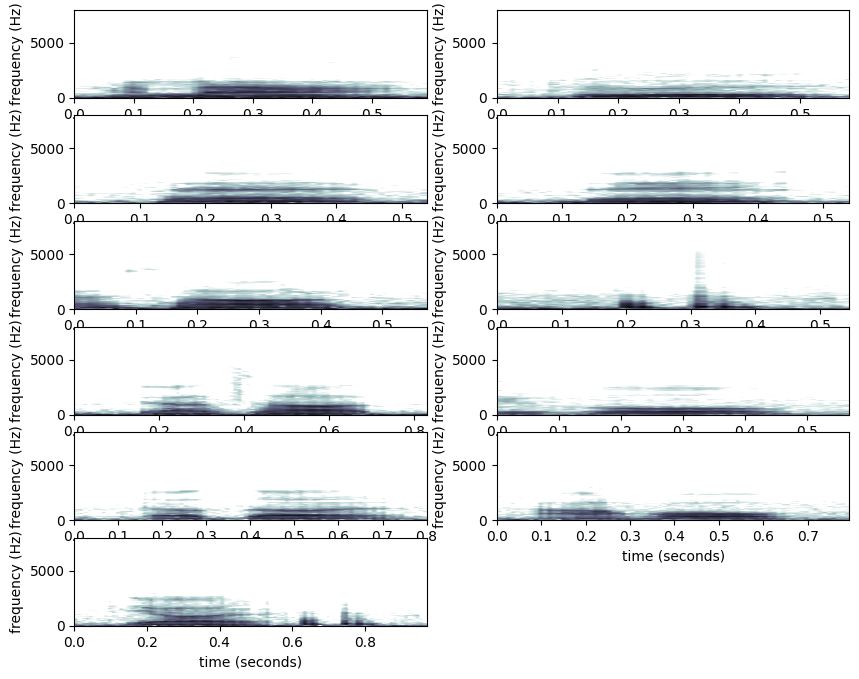

In [247]:
split_wav_noisy = split_with_endpoints(x, epds_noisy, extends=3200)

plot_splits(split_wav_noisy)


### HMM test

Make test dataset using epd

In [275]:
datasetlabels = ['org', 'nbnSNR-10', 'nbnSNR0', 'nbnSNR10', 'wbnSNR-10', 'wbnSNR0', 'wbnSNR10']

testpaths = glob.glob(testroot + '*/*/*')

testwavdict = {}

for testpath in testpaths:
    testwavdict[testpath.split('/')[-2]] = load_unsegmented_wavs(testpath)
    

Noisy data를 대상으로 EPD를 활용한 분할 및 레이블링이 어려워 clean 데이터에서 epd를 활용해 전체 데이터 분할

In [318]:
testmfccdict = {}
testlabeldict = {}

clean_epds = []
for wav in testwavdict['org']:
    epd = find_endpoints(wav, energy_thd=0.1, t_gap_thd=100)
    clean_epds.append(epd)

for label in datasetlabels:
    wavs = testwavdict[label]
    mfccs = []
    labels = []
    for i, wav in enumerate(wavs):
        split_wavs = split_with_endpoints(wav, clean_epds[i], extends=3200)
        for split_wav in split_wavs:
            mfcc = extmfcc_wav(split_wav)
            mfccs.append(mfcc)
        labels.extend([1,2,3,4,5,6,7,8,9,0])    #labels
    
    testmfccdict[label] = mfccs
    testlabeldict[label] = labels

In [319]:
for label in datasetlabels:
    print(label,': ', end='')
    validation_digits_from_features(speechmodels, testlabeldict[label], testmfccdict[label])

org : accuracy = 26.0
nbnSNR-10 : accuracy = 20.0
nbnSNR0 : accuracy = 20.0
nbnSNR10 : accuracy = 28.0
wbnSNR-10 : accuracy = 10.0
wbnSNR0 : accuracy = 10.0
wbnSNR10 : accuracy = 17.0


---
# 3. Noise filtering and HMM testing
ref [lab04_ns_epd](../lab04/lab04_ns_epd.ipynb)

Calculate spectral energy

In [101]:
####################################
def __sumSpect(x, I):
    #plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
    #plt.plot(x[I[0]:I[1]])
    Nt = I[1]-I[0]
    nframes = int((Nt-Nf)//Ns+1)
    Sxx = np.zeros(hNo)   # E[N*conj(N)]
    for n in range(nframes):
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT)
        aX2 = (X*np.conj(X))
        Sxx += aX2[:hNo].real
        
    return Sxx, nframes

####################################
def estSpect(x, IntervalMulti=[]):
    # x: 1-dim time domain signal
    # IntervalMulti:  
    #   2-dim matrix, [n_interval, 2]: multiple intervals
    #   empty list: use all x
    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0, len(x)]])
    #print(IntervalMulti, IntervalMulti.shape)
    
    # accumulate interval power spectral densities
    SxxSum = np.zeros(hNo)   # E[N*conj(N)]
    NumFrames = 0
    for ii in range(IntervalMulti.shape[0]):
        [Sxx, N] = __sumSpect(x, IntervalMulti[ii,:].astype(int))
        SxxSum = SxxSum + Sxx
        NumFrames += N
        
    # average (E[x*conj(x)]
    return SxxSum/NumFrames

Noise filtering

In [102]:
def weiner_filtering(x):
    order = 30
    noverlap = int(Fs*0.003)   # 3ms
    Nx = len(x)

    #minwfgain = 10**(-13/20)    # 0.228
    minwfgain = 10**(-20/20)    # 0.1

    fola = firoverlapadd()
    fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)

    # overlap add 를 할 때는 10ms 씩 shift 해야 한다.
    xbuf = np.zeros(Nf)
    speechest = []

    Snn = estSpect(x, IntervalMulti=np.array([[0.0, 0.5]])*Fs)

    Tx = len(x)
    yout = np.zeros(Nx+fola.getDelay())
    Lout = 0
    xbuf[:] = 0
    t = 0  # time index
    H_a = np.zeros((hNo,0))   # for drawing
    while True:
        t1 = min(t,Nx)      # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
        t2 = min(t+Ns,Nx)   # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함
        
        for ii in range(Nf-Ns):
            xbuf[ii] = xbuf[ii+Ns]
        xbuf[(Nf-Ns):] = 0
        for ii in range(t2-t1):
            xbuf[(Nf-Ns)+ii] = x[t1+ii]
        X = np.fft.fft(xbuf, NFFT)
        aX2 = (X*np.conj(X))
        Syy = aX2[:hNo].real
        Syy = np.maximum(1e-100, Syy)  # to prevent divide by zero
        H = (Syy-Snn)/Syy
        H = np.maximum(minwfgain, H)
        '''
        if t<Ns*10:
            plt.figure(figsize=FIG_SIZE*np.array([1.2,0.9]))
            #plt.plot(H)
            plt.plot(Syy)
            plt.plot(Snn)
            plt.plot(Syy-Snn)
        '''
        H_a = np.column_stack([H_a, np.expand_dims(H,axis=1)])

        h, _ = getLPHFIRFFT(H, order, winname='hamming')
        x = x[t1:t2]
        y, l = fola.doFilterMem(h,x)
        if l > len(yout)-Lout:
            print(len(yout), Lout, len(yout)-Lout, Lout, l)
            l = len(yout)-Lout            
        if l <= 0: break
        
        yout[Lout:(Lout+l)] = y[:l]
        Lout += l
        t += Ns
        
    return yout


In [105]:
x = test_clean_wav[3]

filtered = weiner_filtering(x)

drawspectrogram3(filtered, Fs, NFFT, Ns)


IndexError: index 160 is out of bounds for axis 0 with size 160

HMM test

In [104]:
mfcc_arr = []

for split_wav in split_wav_clean:
    mfcc = extmfcc_wav(split_wav)
    mfcc_arr.append(mfcc)
# test_wav = split_wav_clean[0]

# mfcc = extmfcc_wav(test_wav)

# print(mfcc.shape)
#     mfcc_arr.append(mfcc)
# split_wav_clean
split_wav_clean_label = [0,1,2,3,4,5,6,7,8,9]

In [82]:
scores = []
for speechmodel in speechmodels:
    scores.append(speechmodel.model.score(mfcc_arr[5]))

scores.index(max(scores))

8

In [83]:
print(len(split_wav_clean_label))

10


In [124]:
validation_digits_from_features(speechmodels, split_wav_clean_label, mfcc_arr)

NameError: name 'split_wav_clean_label' is not defined

### 잡음이 있는 데이터에서는 EPD가 제대로 동작하지 않아 잡음이 없는 데이터에서 분할 지점 찾고 레이블링

In [ ]:
epd_list = []
for x in test_clean_wav:
    epds = find_endpoints(x, energy_thd=0.2, t_gap_thd=100, extend=3200)
    print(len(epds))

### Calculate spectral energy
ref: [lab04_ns_epd](../lab04/lab04_ns_epd.ipynb)

In [ ]:
####################################
def __sumSpect(x, I):
    #plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
    #plt.plot(x[I[0]:I[1]])
    Nt = I[1]-I[0]
    nframes = int((Nt-Nf)//Ns+1)
    Sxx = np.zeros(hNo)   # E[N*conj(N)]
    for n in range(nframes):
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT)
        aX2 = (X*np.conj(X))
        Sxx += aX2[:hNo].real
        
    return Sxx, nframes

####################################
def estSpect(x, IntervalMulti=[]):
    # x: 1-dim time domain signal
    # IntervalMulti:  
    #   2-dim matrix, [n_interval, 2]: multiple intervals
    #   empty list: use all x
    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0, len(x)]])
    #print(IntervalMulti, IntervalMulti.shape)
    
    # accumulate interval power spectral densities
    SxxSum = np.zeros(hNo)   # E[N*conj(N)]
    NumFrames = 0
    for ii in range(IntervalMulti.shape[0]):
        [Sxx, N] = __sumSpect(x, IntervalMulti[ii,:].astype(int))
        SxxSum = SxxSum + Sxx
        NumFrames += N
        
    # average (E[x*conj(x)]
    return SxxSum/NumFrames

In [ ]:
order = 30
noverlap = int(Fs*0.003)   # 3ms
Nx = len(filetest)

#minwfgain = 10**(-13/20)    # 0.228
minwfgain = 10**(-20/20)    # 0.1

fola = firoverlapadd()
fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)

# overlap add 를 할 때는 10ms 씩 shift 해야 한다.
xbuf = np.zeros(Nf)
speechest = []

Snn = estSpect(filetest, np.array([[0.0, 0.5]])*Fs)

Tx = len(filetest)
yout = np.zeros(Nx+fola.getDelay())
Lout = 0
xbuf[:] = 0
t = 0  # time index
H_a = np.zeros((hNo,0))   # for drawing
while True:
    t1 = min(t,Nx)      # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
    t2 = min(t+Ns,Nx)   # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함
    
    for ii in range(Nf-Ns):
        xbuf[ii] = xbuf[ii+Ns]
    xbuf[(Nf-Ns):] = 0
    for ii in range(t2-t1):
        xbuf[(Nf-Ns)+ii] = filetest[t1+ii]
    X = np.fft.fft(xbuf, NFFT)
    aX2 = (X*np.conj(X))
    Syy = aX2[:hNo].real
    Syy = np.maximum(1e-100, Syy)  # to prevent divide by zero
    H = (Syy-Snn)/Syy
    H = np.maximum(minwfgain, H)
    '''
    if t<Ns*10:
        plt.figure(figsize=FIG_SIZE*np.array([1.2,0.9]))
        #plt.plot(H)
        plt.plot(Syy)
        plt.plot(Snn)
        plt.plot(Syy-Snn)
    '''
    H_a = np.column_stack([H_a, np.expand_dims(H,axis=1)])

    h, _ = getLPHFIRFFT(H, order, winname='hamming')
    x = filetest[t1:t2]
    y, l = fola.doFilterMem(h,x)
    if l > len(yout)-Lout:
        print(len(yout), Lout, len(yout)-Lout, Lout, l)
        l = len(yout)-Lout            
    if l <= 0: break
    
    yout[Lout:(Lout+l)] = y[:l]
    Lout += l
    t += Ns
    
speechest.append(yout)
# plt.figure(figsize=FIG_SIZE*np.array([1.0,0.5]))
# plt.imshow(H_a, cmap=cmap_plot, aspect='auto', origin='lower')    
drawspectrogram3(yout, Fs, NFFT, Ns)
